# Surrogate Model :

## Problem setup

We consider a 2D acoustic wave equation.
The forward problem consists in computing seismograms at fixed sensors given an epicenter location.

Goal :
- Use a PINN as a surrogate forward model or any other model that coul outperform it
- Use this surrogate to solve an inverse problem (epicenter estimation)

In [85]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from dataclasses import dataclass

# ML pipeline
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype=torch.float32

## Forward models (physics -> seimograms) : 

### Finite difference solver (DP) : 

This solver numerically solves the wave equation using finite differences.
It is treated as the reference forward operator.

In [49]:
class DPForwardSolver:
    """
    Differentiable-physics forward solver for the 2D acoustic wave equation
    using an explicit second-order finite-difference time-stepping scheme.

    forward(e_x, e_y) -> seismograms (Nt, K)
    """

    def __init__(
        self,
        sensors: torch.Tensor,         # (K,2) in physical coords
        c=1,
        x_min=-1, x_max=1,
        y_min=-1, y_max=1,
        Nx=101, Ny=101, Nt=201, T=1,
        # source params
        A=5, beta=200, t0=0.2, gamma=200,
    ):

        self.device = device
        self.dtype = dtype

        # domain / grid
        self.x_min, self.x_max = x_min, x_max
        self.y_min, self.y_max = y_min, y_max
        self.Nx, self.Ny, self.Nt, self.T = Nx, Ny, Nt, T

        # physics
        self.c = torch.as_tensor(c, device=self.device, dtype=self.dtype)

        # source
        self.A = A
        self.beta = beta
        self.t0 = t0
        self.gamma = gamma

        # sensors
        self.sensors = sensors.to(self.device, dtype=self.dtype)
        self.K = self.sensors.shape[0]

        # build grid
        self.x = torch.linspace(self.x_min, self.x_max, self.Nx, device=self.device, dtype=self.dtype)
        self.y = torch.linspace(self.y_min, self.y_max, self.Ny, device=self.device, dtype=self.dtype)

        self.dx = self.x[1] - self.x[0]
        self.dy = self.y[1] - self.y[0]
        if abs(self.dx - self.dy) > 1e-7:
            raise ValueError("DPForwardSolver2D requires dx == dy (uniform square grid) for this stencil.")
        self.h = self.dx

        self.dt = self.T / (self.Nt - 1)

        # CFL check
        if self.c * self.dt / self.h > 1 / math.sqrt(2):
            raise ValueError("CFL unstable: decrease dt (increase Nt), increase h (decrease Nx/Ny), or reduce c.")

        # meshgrid for source evaluation (Ny, Nx)
        X, Y = torch.meshgrid(self.x, self.y, indexing="xy")  # (Nx,Ny)
        self.X = X.T.contiguous()  # (Ny,Nx)
        self.Y = Y.T.contiguous()        

    def get_bounds(self):
        return (self.x_min, self.x_max), (self.y_min, self.y_max)

    def _laplacian(self, u: torch.Tensor) -> torch.Tensor:
        # u: (1,1,Ny,Nx)
        k = torch.tensor([[0, 1, 0],
                          [1,-4, 1],
                          [0, 1, 0]], 
                          device=self.device, dtype=self.dtype) / (self.h * self.h)
        k = k.view(1, 1, 3, 3)
        return F.conv2d(u, k, padding=1)

    def _apply_dirichlet(self, u: torch.Tensor) -> torch.Tensor:
        # avoid in-place ops that can break autograd
        v = u.clone()
        v[..., 0, :] = 0
        v[..., -1, :] = 0
        v[..., :, 0] = 0
        v[..., :, -1] = 0
        return v

    def _source(self, t: torch.Tensor, e_x: torch.Tensor, e_y: torch.Tensor) -> torch.Tensor:
        # returns (1,1,Ny,Nx)
        time_env = self.A * torch.exp(-self.beta * (t - self.t0) ** 2)
        space_env = torch.exp(-self.gamma * ((self.X - e_x) ** 2 + (self.Y - e_y) ** 2))
        f = time_env * space_env
        return f.unsqueeze(0).unsqueeze(0)

    def _sample_sensors(self, u: torch.Tensor) -> torch.Tensor:
        # u: (1,1,Ny,Nx) -> (K,)
        x = self.sensors[:, 0]
        y = self.sensors[:, 1]
        x_n = 2 * (x - self.x_min) / (self.x_max - self.x_min) - 1
        y_n = 2 * (y - self.y_min) / (self.y_max - self.y_min) - 1
        grid = torch.stack([x_n, y_n], dim=-1).view(1, -1, 1, 2)  # (1,K,1,2)
        vals = F.grid_sample(u, grid, mode="bilinear", align_corners=True)  # (1,1,K,1)
        return vals.view(-1)

    def forward(self, e_x, e_y):
        """
        e_x, e_y: epicenter coordinates (float, tensor, or nn.Parameter)

        seismograms: (Nt, K)
        optionally u_curr: (1,1,Ny,Nx) final field if return_wavefield=True
        """
        # if not isinstance(e_x, torch.Tensor):
        #     e_x = torch.tensor(e_x, device=self.device, dtype=self.dtype)
        # else:
        #     e_x = e_x.to(device=self.device, dtype=self.dtype)

        # if not isinstance(e_y, torch.Tensor):
        #     e_y = torch.tensor(e_y, device=self.device, dtype=self.dtype)
        # else:
        #     e_y = e_y.to(device=self.device, dtype=self.dtype)
        if not isinstance(e_x, torch.Tensor):
            e_x = torch.tensor(float(e_x), device=self.device, dtype=self.dtype)
        else:
            if e_x.device != self.device:
                e_x = e_x.to(self.device)
            if e_x.dtype != self.dtype:
                e_x = e_x.to(self.dtype)

        if not isinstance(e_y, torch.Tensor):
            e_y = torch.tensor(float(e_y), device=self.device, dtype=self.dtype)
        else:
            if e_y.device != self.device:
                e_y = e_y.to(self.device)
            if e_y.dtype != self.dtype:
                e_y = e_y.to(self.dtype)

        u_prev = torch.zeros((1, 1, self.Ny, self.Nx), device=self.device, dtype=self.dtype)
        u_curr = torch.zeros((1, 1, self.Ny, self.Nx), device=self.device, dtype=self.dtype)

        seismograms = torch.zeros((self.Nt, self.K), device=self.device, dtype=self.dtype)

        cdt2 = (self.c * self.dt) ** 2
        dt2 = (self.dt ** 2)

        for n in range(self.Nt):
            t = torch.as_tensor(n * self.dt, device=self.device, dtype=self.dtype)

            seismograms[n] = self._sample_sensors(u_curr)

            if n < self.Nt - 1:
                lap = self._laplacian(u_curr)
                f = self._source(t, e_x, e_y)
                u_next = 2 * u_curr - u_prev + cdt2 * lap + dt2 * f
                u_next = self._apply_dirichlet(u_next)
                u_prev, u_curr = u_curr, u_next

        return seismograms

### PINN surrogate model : 

The PINN approximates the continuous wavefield $u(x,y,t; e_x,e_y)$.

Epicenter coordinates are given as inputs such that a single network can represent multiple source locations.

$f_\theta :
(e_x,e_y)
\;\longmapsto\;
\mathcal S_\theta(e_x,e_y)
\;=\;
\left\{
\hat u_\theta(x_k,y_k,t_n;e_x,e_y)
\right\}_{n=1..N_t,\;k=1..K}$


In [50]:
class PINN(nn.Module):
    def __init__(self, width=128, depth=8, act=nn.Tanh):
        super().__init__()
        layers = [nn.Linear(5, width), act()]
        for _ in range(depth - 1):
            layers += [nn.Linear(width, width), act()]
        layers += [nn.Linear(width, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, x, y, t, e_x, e_y):
        X = torch.stack([x, y, t, e_x, e_y], dim=-1)  
        return self.net(X).squeeze(-1)



class PINNForwardSolver2D:
    def __init__(
        self,
        model: nn.Module,
        sensors: torch.Tensor,   # (K,2)
        Nt: int,
        T: float,
        x_min=-1.0, x_max=1.0,
        y_min=-1.0, y_max=1.0,
        device=None,
        dtype=torch.float32,
        batch_size=4096,
    ):
        self.model = model
        self.device = device if device is not None else next(model.parameters()).device
        self.dtype = dtype

        self.sensors = sensors.to(self.device, dtype=self.dtype)
        self.K = int(self.sensors.shape[0])

        self.Nt = int(Nt)
        self.T = float(T)
        self.dt = self.T / (self.Nt - 1)
        self.t_grid = torch.linspace(0, self.T, self.Nt, device=self.device, dtype=self.dtype)

        self.x_min, self.x_max = float(x_min), float(x_max)
        self.y_min, self.y_max = float(y_min), float(y_max)

        self.batch_size = int(batch_size)

    def get_bounds(self):
        return (self.x_min, self.x_max), (self.y_min, self.y_max)

    def forward(self, e_x, e_y):
        # keep autograd on e_x,e_y for inversion (do not detach/cast)
        x_s = self.sensors[:, 0]
        y_s = self.sensors[:, 1]

        traces = torch.empty((self.Nt, self.K), device=self.device, dtype=self.dtype)

        for n in range(self.Nt):
            t = self.t_grid[n]
            start = 0
            while start < self.K:
                end = min(start + self.batch_size, self.K)
                xs = x_s[start:end]
                ys = y_s[start:end]
                ts = t.expand_as(xs)
                ex = e_x.expand_as(xs)
                ey = e_y.expand_as(xs)
                traces[n, start:end] = self.model(xs, ys, ts, ex, ey)
                start = end
        return traces


#### Physic-informed loss :

We enforce the acoustic wave equation residual at random points.
This term acts as a regularizer and is weighted weakly compared to data loss.

In [51]:
def _grad(u, x, retain_graph=True):
    return torch.autograd.grad(
        outputs=u, 
        inputs=x,
        grad_outputs=torch.ones_like(u),
        create_graph=True, 
        retain_graph=retain_graph
    )[0]

def _laplacian(u, x, y):
    ux = _grad(u, x) 
    uxx = _grad(ux, x)
    uy = _grad(u, y)
    uyy = _grad(uy, y)
    return uxx + uyy


def source_gauss(x, y, t, e_x, e_y, A=5, beta=200, t0=0.2, gamma=200):
    time_env = A * torch.exp(-beta * (t - t0)**2)
    space_env = torch.exp(-gamma * ((x - e_x)**2 + (y - e_y)**2))
    return time_env * space_env

# def pde_residual(model, x, y, t, e_x, e_y, c, A, beta, t0, gamma):
#     x = x.detach().requires_grad_(True)
#     y = y.detach().requires_grad_(True)
#     t = t.detach().requires_grad_(True)

#     u = model(x, y, t, e_x, e_y)
#     ut = _grad(u, t)
#     utt = _grad(ut, t)
#     lap = _laplacian(u, x, y)
#     f = source_gauss(x, y, t, e_x, e_y, A=A, beta=beta, t0=t0, gamma=gamma)
#     return utt - (c**2) * lap - f
def pde_residual(model, x, y, t, e_x, e_y, c, A, beta, t0, gamma):
    x = x.requires_grad_(True)
    y = y.requires_grad_(True)
    t = t.requires_grad_(True)

    u = model(x, y, t, e_x, e_y)
    ut = _grad(u, t)
    utt = _grad(ut, t)
    lap = _laplacian(u, x, y)
    f = source_gauss(x, y, t, e_x, e_y, A=A, beta=beta, t0=t0, gamma=gamma)
    return utt - (c**2) * lap - f


def _ic_loss(model, ex_b, ey_b, cfg, device, dtype):
    # u(x,y,0)=0 and u_t(x,y,0)=0
    n = cfg.N_ic
    x0 = torch.empty(n, device=device, dtype=dtype).uniform_(cfg.x_min, cfg.x_max)
    y0 = torch.empty(n, device=device, dtype=dtype).uniform_(cfg.y_min, cfg.y_max)
    t0 = torch.zeros(n, device=device, dtype=dtype).requires_grad_(True)

    b = torch.randint(0, ex_b.shape[0], (n,), device=device)
    ex = ex_b[b]
    ey = ey_b[b]

    u0 = model(x0, y0, t0, ex, ey)
    ut0 = _grad(u0, t0)
    return (u0**2).mean() + (ut0**2).mean()


def _bc_loss(model, ex_b, ey_b, cfg, device, dtype):
    # Dirichlet u=0 on boundary
    n = cfg.N_bc
    t = torch.empty(n, device=device, dtype=dtype).uniform_(0.0, cfg.T)

    side = torch.randint(0, 4, (n,), device=device)
    x = torch.empty(n, device=device, dtype=dtype)
    y = torch.empty(n, device=device, dtype=dtype)

    m = side == 0  # left
    x[m] = cfg.x_min
    y[m] = torch.empty(m.sum(), device=device, dtype=dtype).uniform_(cfg.y_min, cfg.y_max)

    m = side == 1  # right
    x[m] = cfg.x_max
    y[m] = torch.empty(m.sum(), device=device, dtype=dtype).uniform_(cfg.y_min, cfg.y_max)

    m = side == 2  # bottom
    y[m] = cfg.y_min
    x[m] = torch.empty(m.sum(), device=device, dtype=dtype).uniform_(cfg.x_min, cfg.x_max)

    m = side == 3  # top
    y[m] = cfg.y_max
    x[m] = torch.empty(m.sum(), device=device, dtype=dtype).uniform_(cfg.x_min, cfg.x_max)

    b = torch.randint(0, ex_b.shape[0], (n,), device=device)
    ex = ex_b[b]
    ey = ey_b[b]

    u = model(x, y, t, ex, ey)
    return (u**2).mean()

#### Training the PINN surrogate : 

At each epoch :
- Epicenters are resampled
- DP seismograms are generated
- The PINN is trained to match DP traces at sensor locations

The data loss dominates, physics acts as regularization.

In [52]:
# Training configuration for the PINN surrogate model
@dataclass
class TrainCfg:
    x_min: float = -1
    x_max: float =  1
    y_min: float = -1
    y_max: float =  1
    T: float = 1

    c: float = 1
    A: float = 5
    beta: float = 200
    t0: float = 0.2
    gamma: float = 200

    epochs: int = 8000
    lr: float = 1e-3

    B: int = 1
    N_phys: int = 2048
    N_ic: int = 2048
    N_bc: int = 2048

    # field-first: physics dominates
    w_phys: float = 1
    w_ic: float   = 1
    w_bc: float   = 1

    # optional tiny anchor to DP traces (set 0.0 to remove)
    w_data: float = 0
    N_data: int = 2048  # number of (sensor,time) anchor points per epoch

    print_every: int = 200

@torch.no_grad()
def _sample_epicenters(B, x_min, x_max, y_min, y_max, device, dtype):
    ex = torch.empty(B, device=device, dtype=dtype).uniform_(x_min, x_max)
    ey = torch.empty(B, device=device, dtype=dtype).uniform_(y_min, y_max)
    return ex, ey


# def train_pinn(
#     model: nn.Module,
#     dp_forward_solver,      
#     sensors: torch.Tensor,
#     Nt: int,
#     cfg: TrainCfg,
#     device,
#     dtype=torch.float32,
# ):
#     model = model.to(device=device, dtype=dtype).train()
#     sensors = sensors.to(device=device, dtype=dtype)
#     K = sensors.shape[0]

#     # time grid
#     t_grid = torch.linspace(0, cfg.T, Nt, device=device, dtype=dtype) # must match dp_forward_solver dt/T

#     # scale per sensor 
#     scale = None
#     if cfg.normalize_per_sensor:
#         with torch.no_grad():
#             W = int(cfg.warmup_sims)
#             ex_w, ey_w = _sample_epicenters(W, cfg.x_min, cfg.x_max, cfg.y_min, cfg.y_max, device, dtype)
#             Yw = torch.stack([dp_forward_solver.forward(ex_w[i], ey_w[i]) for i in range(W)], dim=0)  # (W,Nt,K)
#             scale = Yw.reshape(-1, K).std(dim=0, unbiased=False).clamp_min(1e-6)  # (K,)

#     c_t = torch.as_tensor(cfg.c, device=device, dtype=dtype)

#     opt = torch.optim.Adam(model.parameters(), lr=cfg.lr)
#     mse = nn.MSELoss()

#     Xs = sensors[:, 0].view(1, K).expand(Nt, K)
#     Ys = sensors[:, 1].view(1, K).expand(Nt, K)
#     Ts = t_grid.view(Nt, 1).expand(Nt, K)

#     for ep in range(1, cfg.epochs + 1):
#         opt.zero_grad(set_to_none=True)

#         # Sample epicenters (new epicenters each epoch)
#         ex_b, ey_b = _sample_epicenters(cfg.B, cfg.x_min, cfg.x_max, cfg.y_min, cfg.y_max, device, dtype)

#         # Targets (B,Nt,K) 
#         with torch.no_grad():
#             Yb = torch.stack([dp_forward_solver.forward(ex_b[i], ey_b[i]) for i in range(cfg.B)], dim=0)

#         # Predictions (B,Nt,K)
#         preds_list = []
#         for i in range(cfg.B):
#             ex = ex_b[i].expand_as(Xs)
#             ey = ey_b[i].expand_as(Xs)
#             ui = model(
#                 Xs.reshape(-1), Ys.reshape(-1), Ts.reshape(-1),
#                 ex.reshape(-1), ey.reshape(-1)
#             ).view(Nt, K)
#             preds_list.append(ui)

#         preds = torch.stack(preds_list, dim=0)  # (B,Nt,K)

#         # normalize per sensor
#         if scale is not None:
#             preds_n = preds / scale.view(1, 1, K)
#             Yb_n = Yb / scale.view(1, 1, K)
#         else:
#             preds_n = preds
#             Yb_n = Yb

#         L_data = mse(preds_n, Yb_n)

#         # physics loss 
#         x_p = torch.empty(cfg.N_phys, device=device, dtype=dtype).uniform_(cfg.x_min, cfg.x_max)
#         y_p = torch.empty(cfg.N_phys, device=device, dtype=dtype).uniform_(cfg.y_min, cfg.y_max)
#         t_p = torch.empty(cfg.N_phys, device=device, dtype=dtype).uniform_(0.0, cfg.T)

#         b2 = torch.randint(0, cfg.B, (cfg.N_phys,), device=device)
#         ex_p = ex_b[b2]
#         ey_p = ey_b[b2]

#         R = pde_residual(model, x_p, y_p, t_p, ex_p, ey_p, c_t, cfg.A, cfg.beta, cfg.t0, cfg.gamma)
#         L_phys = torch.mean(R**2)
#         # L_ic = _ic_loss(model, ex_b, ey_b, cfg, device, dtype)
#         # L_bc = _bc_loss(model, ex_b, ey_b, cfg, device, dtype)

#         loss = cfg.w_data * L_data + cfg.w_phys * L_phys #+ cfg.w_ic * L_ic + cfg.w_bc * L_bc
#         loss.backward()
#         opt.step()

#         if (ep % cfg.print_every == 0) or (ep == 1):
#             print(f"ep {ep:04d}  total={loss.item():.3e}  data={L_data.item():.3e}  phys={L_phys.item():.3e}") # ic={L_ic.item():.3e}  bc={L_bc.item():.3e}")
#     model.eval()
#     return model, scale

def train_pinn(
    model: nn.Module,
    dp_forward_solver,      # keep only if you want optional tiny anchor (w_data>0)
    sensors: torch.Tensor,  # keep only if you want optional tiny anchor (w_data>0)
    Nt: int,                # keep only if you want optional tiny anchor (w_data>0)
    cfg: TrainCfg,
    device,
    dtype=torch.float32,
):
    model = model.to(device=device, dtype=dtype).train()
    opt = torch.optim.Adam(model.parameters(), lr=cfg.lr)
    mse = nn.MSELoss()

    c_t = torch.as_tensor(cfg.c, device=device, dtype=dtype)

    # precompute time grid only for optional anchor
    if cfg.w_data > 0.0:
        sensors = sensors.to(device=device, dtype=dtype)
        K = sensors.shape[0]
        t_grid = torch.linspace(0.0, cfg.T, Nt, device=device, dtype=dtype)

    for ep in range(1, cfg.epochs + 1):
        opt.zero_grad(set_to_none=True)

        # sample epicenters
        ex_b, ey_b = _sample_epicenters(cfg.B, cfg.x_min, cfg.x_max, cfg.y_min, cfg.y_max, device, dtype)

        # ---- PHYSICS: interior residual over full domain (fit u) ----
        nP = cfg.B * cfg.N_phys
        x_p = torch.empty(nP, device=device, dtype=dtype).uniform_(cfg.x_min, cfg.x_max)
        y_p = torch.empty(nP, device=device, dtype=dtype).uniform_(cfg.y_min, cfg.y_max)
        t_p = torch.empty(nP, device=device, dtype=dtype).uniform_(0.0, cfg.T)

        bP = torch.randint(0, cfg.B, (nP,), device=device)
        ex_p = ex_b[bP]
        ey_p = ey_b[bP]

        R = pde_residual(model, x_p, y_p, t_p, ex_p, ey_p, c_t, cfg.A, cfg.beta, cfg.t0, cfg.gamma)
        L_phys = (R**2).mean()

        # ---- IC/BC: enforce uniqueness of the PDE solution ----
        L_ic = _ic_loss(model, ex_b, ey_b, cfg, device, dtype)
        L_bc = _bc_loss(model, ex_b, ey_b, cfg, device, dtype)

        # ---- OPTIONAL tiny anchor to DP traces (do NOT dominate) ----
        L_data = torch.zeros((), device=device, dtype=dtype)
        if cfg.w_data > 0:
            # sample random (sensor,time) points
            idx_k = torch.randint(0, K, (cfg.N_data,), device=device)
            idx_t = torch.randint(0, Nt, (cfg.N_data,), device=device)
            idx_b = torch.randint(0, cfg.B, (cfg.N_data,), device=device)

            x_d = sensors[idx_k, 0]
            y_d = sensors[idx_k, 1]
            t_d = t_grid[idx_t]
            ex_d = ex_b[idx_b]
            ey_d = ey_b[idx_b]

            u_hat = model(x_d, y_d, t_d, ex_d, ey_d)

            with torch.no_grad():
                # teacher traces for those epicenters (compute only what you need)
                # simplest (not fastest): compute full trace for each used epicenter once
                uniq = torch.unique(idx_b)
                Y = {}
                for b in uniq.tolist():
                    Y[b] = dp_forward_solver.forward(ex_b[b], ey_b[b])  # (Nt,K)
                u_ref = torch.stack([Y[int(b)][int(ti), int(ki)] for b,ti,ki in zip(idx_b, idx_t, idx_k)]).to(device)

            L_data = mse(u_hat, u_ref)

        loss = cfg.w_phys * L_phys + cfg.w_ic * L_ic + cfg.w_bc * L_bc + cfg.w_data * L_data
        loss.backward()
        opt.step()

        if (ep % cfg.print_every == 0) or (ep == 1):
            print(
                f"ep {ep:04d} total={loss.item():.3e} "
                f"phys={L_phys.item():.3e} ic={L_ic.item():.3e} bc={L_bc.item():.3e} data={L_data.item():.3e}"
            )

    model.eval()
    return model

#### Helper functions : 
Save and load the trained PINN.

In [53]:
# Save and load the trainned model (ChatGPT was used to generate this code)
def save_pinn(path, model, cfg: TrainCfg):
    torch.save(
        {
            "state": model.state_dict(),
            "cfg": cfg.__dict__,
            "arch": {
                "width": model.net[0].out_features,
                "depth": (len(model.net) - 2)//2 + 1
            },
        },
        path,
    )

def load_pinn(path, device, dtype=torch.float32):
    ckpt = torch.load(path, map_location="cpu")
    cfg = TrainCfg(**ckpt["cfg"])
    arch = ckpt["arch"]
    model = PINN(width=arch["width"], depth=arch["depth"]).to(device=device, dtype=dtype)
    model.load_state_dict(ckpt["state"])
    model.eval()
    return model, cfg


### Neural Network :

This model is a supervised neural network baseline used to approximate the wavefield  from data generated by the DP solver, without any physics constraints. 

- Input: spatial position, time, epicenter  
- Output: scalar displacement \(u\)  
- Training: supervised learning with **Smooth L1 loss**  
- Normalization applied to inputs and outputs


In [86]:
class Neural_Network(nn.Module):
    def __init__(self, width=256, depth=5):
        super().__init__()
        layers = [nn.Linear(5, width), nn.SiLU()]
        for _ in range(depth - 1):
            layers += [nn.Linear(width, width), nn.SiLU()]
        layers += [nn.Linear(width, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, x, y, t, e_x, e_y):
        X = torch.stack([x, y, t, e_x, e_y], dim=-1)
        return self.net(X).squeeze(-1)


def train_nn(model, X, y, epochs=50, batch_size=4096, lr=1e-3):
    dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(X).float(),
        torch.from_numpy(y).float()
    )
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.SmoothL1Loss(beta=0.5)

    model.train()
    for ep in range(epochs):
        total = 0
        for x_batch, y_batch in loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            pred = model(x_batch[:,0], x_batch[:,1], x_batch[:,2], x_batch[:,3], x_batch[:,4])
            loss = loss_fn(pred, y_batch)

            opt.zero_grad()
            loss.backward()
            opt.step()

            total += loss.item() * x_batch.size(0)

        if ep % 10 == 0:
            print(f"ep {ep:03d}  mse={total/len(dataset):.3e}")

    model.eval()
    return model

class NNForwardSolver:
    def __init__(self, model, sensors, Nt, T, device, X_mean, X_std, y_mean, y_std):
        self.model = model
        self.sensors = sensors.to(device)
        self.Nt = Nt
        self.T = T
        self.dt = T / (Nt - 1)
        self.t_grid = torch.linspace(0, T, Nt, device=device)

        self.X_mean = torch.tensor(X_mean, device=device, dtype=torch.float32)
        self.X_std  = torch.tensor(X_std,  device=device, dtype=torch.float32)
        self.y_mean = y_mean
        self.y_std  = y_std

    def get_bounds(self):
        return (-1, 1), (-1, 1)  # hard coded for now

    def forward(self, e_x, e_y):
        K = self.sensors.shape[0]
        traces = torch.empty((self.Nt, K), device=self.sensors.device)

        xs = self.sensors[:, 0]
        ys = self.sensors[:, 1]

        for n, t in enumerate(self.t_grid):
            ts = t.expand_as(xs)
            ex = e_x.expand_as(xs)
            ey = e_y.expand_as(xs)

            X = torch.stack([xs, ys, ts, ex, ey], dim=-1)
            Xn = (X - self.X_mean) / self.X_std

            u_n = self.model(Xn[:,0], Xn[:,1], Xn[:,2], Xn[:,3], Xn[:,4])
            u = u_n * self.y_std + self.y_mean
            traces[n] = u

        return traces

This function builds a supervised dataset to train a NN. It learns the seismograms at sensors, not the full wavefield u(x,y,t).

In [ ]:
# Function generated using ChatGPT 
def make_dataset(dp_forward_solver, sensors, Nt, T,
                 n_epicenters=256, n_pairs_per_epi=1024,
                 x_min=-1.0, x_max=1.0, y_min=-1.0, y_max=1.0,
                 seed=42, print_every=25):
    rng = np.random.default_rng(seed)

    sensors_np = sensors.detach().cpu().numpy().astype(np.float32)
    K = sensors_np.shape[0]
    t_grid = np.linspace(0.0, float(T), int(Nt), dtype=np.float32)

    N = int(n_epicenters) * int(n_pairs_per_epi)
    X = np.empty((N, 5), dtype=np.float32)
    y = np.empty((N,), dtype=np.float32)

    ex_all = rng.uniform(x_min, x_max, size=n_epicenters).astype(np.float32)
    ey_all = rng.uniform(y_min, y_max, size=n_epicenters).astype(np.float32)

    for i, (ex, ey) in enumerate(zip(ex_all, ey_all)):
        if (i % print_every) == 0:
            print(i, "/", n_epicenters, flush=True)

        with torch.no_grad():
            Y = dp_forward_solver.forward(float(ex), float(ey)).detach().cpu().numpy().astype(np.float32)  # (Nt,K)

        idx_k = rng.integers(0, K, size=n_pairs_per_epi)
        # idx_t = rng.integers(0, Nt, size=n_pairs_per_epi)
        n = n_pairs_per_epi 
        n1 = n // 5 
        n2 = n - n1 
        idx_t1 = rng.integers(0, Nt, size=n1) 
        idx_t2 = rng.integers(int(0.75 * Nt), Nt, size=n2) 
        idx_t = np.concatenate([idx_t1, idx_t2]) 
        rng.shuffle(idx_t) 

        xs = sensors_np[idx_k, 0]
        ys = sensors_np[idx_k, 1]
        ts = t_grid[idx_t]

        j0 = i * n_pairs_per_epi
        j1 = j0 + n_pairs_per_epi

        X[j0:j1, 0] = xs
        X[j0:j1, 1] = ys
        X[j0:j1, 2] = ts
        X[j0:j1, 3] = ex
        X[j0:j1, 4] = ey

        y[j0:j1] = Y[idx_t, idx_k]

    return X, y

### ML pipeline :

In [ ]:
# Function generated with ChatGPT 
def predict_traces(model, sensors, Nt, T, e_x, e_y):
    """
    Use a fitted sklearn model to predict traces (Nt,K) for one epicenter.
    """
    sensors_np = sensors.detach().cpu().numpy().astype(np.float32)
    K = sensors_np.shape[0]
    t_grid = np.linspace(0.0, float(T), int(Nt)).astype(np.float32)

    xs = np.repeat(sensors_np[:, 0][None, :], Nt, axis=0).reshape(-1)
    ys = np.repeat(sensors_np[:, 1][None, :], Nt, axis=0).reshape(-1)
    ts = np.repeat(t_grid[:, None], K, axis=1).reshape(-1)

    exs = np.full_like(ts, float(e_x), dtype=np.float32)
    eys = np.full_like(ts, float(e_y), dtype=np.float32)

    Xq = np.stack([xs, ys, ts, exs, eys], axis=1).astype(np.float32)
    uq = model.predict(Xq).astype(np.float32).reshape(Nt, K)

    return torch.from_numpy(uq)

## Inverse problem solver :

Given the observed seismograms $\mathcal S_{\text{obs}}$, it estimates the epicenter $(e_x,e_y)$ by minimizing the difference between observed and the predicted seismograms using gradient-based optimization.

$(e_x^*, e_y^*) \;=\; \arg\min_{(e_x,e_y)} \; \left\| \mathcal S_\theta(e_x,e_y) - \mathcal S_{\text{obs}} \right\|^2$

In [56]:
def inverse_solver(
    forward,               # object with: forward(e_x, e_y) -> traces_pred (Nt,K)
    traces_obs,            # (Nt,K) torch tensor
    dt,                    # float
    t_star=0,              # ignore data before t_star
    init=(0, 0),           # initial guess (e_x0, e_y0)
    steps=25,             # outer steps
    lr=1,
    lam=1e-6
):
    """
    Inverse solver.
    Forward(e_x,e_y) returns predicted seismograms

    Returns:
      e_hat: (2,) tensor [e_x_hat, e_y_hat]
      traces_pred_final: (Nt,K) tensor
      history: list of dicts (optional diagnostics)
      n_star: int
    """
    traces_obs = traces_obs.to(device=device, dtype=dtype)

    Nt = traces_obs.shape[0]
    n_star = int(round(t_star / dt))
    n_star = max(0, min(n_star, Nt - 1))

    # trainable epicenter
    e_x = torch.nn.Parameter(torch.tensor(float(init[0]), device=device, dtype=dtype))
    e_y = torch.nn.Parameter(torch.tensor(float(init[1]), device=device, dtype=dtype))

    def clamp():
        (x_min, x_max), (y_min, y_max) = forward.get_bounds()
        with torch.no_grad():
            e_x.clamp_(x_min + 1e-3, x_max - 1e-3)
            e_y.clamp_(y_min + 1e-3, y_max - 1e-3)
    clamp()

    # fixed scaling based on observed data (stabilizes 2-sensors case)
    scale = traces_obs[n_star:].std(dim=0, unbiased=False).clamp_min(1e-6)

    opt = torch.optim.LBFGS([e_x, e_y], lr=lr, max_iter=20, line_search_fn="strong_wolfe")
    history = []

    def loss_and_pred():
        traces_pred = forward.forward(e_x, e_y)  # (Nt,K)
        pred = traces_pred[n_star:]
        obs = traces_obs[n_star:]

        pred = pred / scale
        obs = obs / scale

        loss_data = torch.sum((pred - obs) ** 2)
        loss_reg = lam * (e_x**2 + e_y**2)
        return loss_data + loss_reg, loss_data, traces_pred

    for it in range(int(steps)):
        def closure():
            opt.zero_grad()
            loss, _, _ = loss_and_pred()
            loss.backward()
            return loss

        opt.step(closure)
        clamp()

        if it % 5 == 0 or it == steps - 1:
            print(f"{it=}")
            with torch.no_grad():
                loss, loss_data, _ = loss_and_pred()
                history.append({
                    "it": it,
                    "loss": float(loss.item()),
                    "loss_data": float(loss_data.item()),
                    "e_x": float(e_x.item()),
                    "e_y": float(e_y.item()),
                })

    with torch.no_grad():
        _, _, traces_pred_final = loss_and_pred()

    e_hat = torch.stack([e_x.detach(), e_y.detach()])
    return e_hat, traces_pred_final.detach(), history, n_star

## Comparisons : 

Here, the different models, configurations and scenarios are tested and compared to each other.

### Scenario 1 : all information are known except $(e_x, e_y)$

#### Forward solvers :

In [ ]:
sensors = torch.tensor([[-0.9, -0.2],
                        [ 0.6,  0.8]], 
                        dtype=torch.float32, device=device)

e_true = (0.25, -0.10)

dp_forward_solver = DPForwardSolver(sensors=sensors)
Nt = dp_forward_solver.Nt

X, y = make_dataset(dp_forward_solver, sensors, Nt, T=dp_forward_solver.T,
                    n_epicenters=256, n_pairs_per_epi=1024)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.15, random_state=42)

In [ ]:
# --- train (physics-first / fit u) ---
# config -> pinn_physics_only
# cfg = TrainCfg(
#     T=1,
#     c=1, A=5, beta=200, t0=0.2, gamma=200,
#     epochs=4000,
#     lr=1e-3,

#     B=8,
#     N_phys=1024,
#     N_ic=512,
#     N_bc=512,

#     # physics-first weights
#     w_phys=1,
#     w_ic=1,
#     w_bc=1,

#     # optional tiny anchor to DP traces (set to 0.0 to remove)
#     w_data=0,#1e-3,    
#     N_data=2048,

#     print_every=250,
# )

# Config pinn_physics_only2
# cfg = TrainCfg(
#     T=1,
#     c=1, A=5, beta=200, t0=0.2, gamma=200,
#     epochs=4000,
#     lr=1e-3,

#     B=8,
#     N_phys=512,
#     N_ic=512,
#     N_bc=512,

#     w_phys=1,
#     w_ic=1,
#     w_bc=1,

#     w_data=1e-4,
#     N_data=512,

#     print_every=250,
# )

# Config pinn_physics_only3
cfg = TrainCfg(
    T=1,
    c=1, A=5, beta=200, t0=0.2, gamma=200,
    epochs=4000,
    lr=1e-3,

    B=8,
    N_phys=512,
    N_ic=512,
    N_bc=512,

    w_phys=1.0,
    w_ic=0.1,
    w_bc=0.1,

    w_data=1e-3,
    N_data=2048,

    print_every=250,
)

# Config pinn_physics_only4 (more epochs, stronger data anchor)
cfg = TrainCfg(
    T=1,
    c=1, A=5, beta=200, t0=0.2, gamma=200,
    epochs=3000,
    lr=1e-3,

    B=8,
    N_phys=2048,
    N_ic=1024,
    N_bc=1024,

    w_phys=1,
    w_ic=0.9,
    w_bc=0.9,

    w_data=1e-2,     
    N_data=4096,

    print_every=250,
)

model_pinn = PINN(width=128, depth=8).to(device)

model_pinn = train_pinn(
    model=model_pinn,
    dp_forward_solver=dp_forward_solver,  # only used if w_data > 0
    sensors=sensors,                      # only used if w_data > 0
    Nt=Nt,                                # only used if w_data > 0
    cfg=cfg,
    device=device,
)

save_pinn("pinn_physics_only4.pt", model_pinn, cfg)

ep 0001 total=2.248e-02 phys=8.222e-03 ic=7.873e-03 bc=7.887e-03 data=7.762e-03
ep 0250 total=1.263e-03 phys=1.262e-03 ic=9.083e-07 bc=5.160e-07 data=1.413e-06
ep 0500 total=4.305e-03 phys=4.299e-03 ic=5.029e-06 bc=2.524e-06 data=2.520e-06
ep 0750 total=2.553e-03 phys=2.533e-03 ic=1.322e-05 bc=9.531e-06 data=1.231e-05
ep 1000 total=2.873e-04 phys=2.249e-04 ic=6.516e-05 bc=4.132e-06 data=5.619e-06
ep 1250 total=2.213e-04 phys=1.850e-04 ic=3.728e-05 bc=3.040e-06 data=3.385e-06
ep 1500 total=8.818e-05 phys=6.515e-05 ic=2.274e-05 bc=2.814e-06 data=3.002e-06


In [92]:
# model_pinn, cfg = load_pinn("pinn_physics_only2.pt", device=device) # uncomment when loading a saved model

forward_pinn = PINNForwardSolver2D(
    model=model_pinn,
    sensors=sensors,
    Nt=Nt,
    T=cfg.T,
    x_min=cfg.x_min, x_max=cfg.x_max,
    y_min=cfg.y_min, y_max=cfg.y_max,
    device=device,
)

In [ ]:
neural_network = Neural_Network(width=256, depth=5).to(device)

# normalize
X_mean = Xtr.mean(axis=0)
X_std  = Xtr.std(axis=0) + 1e-12
y_mean = ytr.mean()
y_std  = ytr.std() + 1e-12

Xtr_n = (Xtr - X_mean) / X_std
Xte_n = (Xte - X_mean) / X_std
ytr_n = (ytr - y_mean) / y_std
yte_n = (yte - y_mean) / y_std

# train supervised on the dataset generated from DP traces
neural_network = train_nn(neural_network, Xtr_n, ytr_n, epochs=200, batch_size=4096, lr=1e-3)

forward_nn = NNForwardSolver(neural_network, sensors, Nt, dp_forward_solver.T, device, X_mean, X_std, y_mean, y_std)


ep 000  mse=3.185e-01
ep 010  mse=8.266e-03
ep 020  mse=1.910e-03
ep 030  mse=1.242e-03
ep 040  mse=9.775e-04
ep 050  mse=9.208e-04
ep 060  mse=9.483e-04
ep 070  mse=8.852e-04
ep 080  mse=4.524e-04
ep 090  mse=5.325e-04
ep 100  mse=1.071e-03
ep 110  mse=2.561e-04
ep 120  mse=6.216e-04
ep 130  mse=4.154e-04
ep 140  mse=5.481e-04
ep 150  mse=4.094e-04
ep 160  mse=3.195e-04
ep 170  mse=1.567e-04
ep 180  mse=3.139e-04
ep 190  mse=5.031e-04


In [ ]:
model_ml = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_leaf=2,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42,
)
model_ml.fit(Xtr, ytr)
# print("test MSE:", mean_squared_error(yte, model_ml.predict(Xte)))


test MSE: 1.7460923014449363e-09


### Inverse solver :

Reference seismograms :

In [46]:
with torch.no_grad():
    traces_obs = dp_forward_solver.forward(*e_true)


##### DP :

Test using DP for the forward operation.

In [60]:
e_hat_dp, traces_pred, history, n_star = inverse_solver(
    forward=dp_forward_solver,
    traces_obs=traces_obs,
    dt=dp_forward_solver.dt,
    t_star=0.35,
    init=(0.0, 0.0),
    steps=50,
    lr=1.0,
    lam=1e-6,
)

it=0
it=5
it=10
it=15
it=20
it=25
it=30
it=35
it=40
it=45
it=49


#### PINN :

Test using the PINN for the forward operation.

In [93]:
e_hat_pinn_t0, traces_pinn_t0, history, n_star = inverse_solver(
    forward=forward_pinn,
    traces_obs=traces_obs,
    dt=forward_pinn.dt,
    t_star=0.0,
    init=(0.0, 0.0),
    steps=50,
    lr=0.2,
    lam=1e-3,
)

e_hat_pinn_t03, traces_pinn_t03, history, n_star = inverse_solver(
    forward=forward_pinn,
    traces_obs=traces_obs,
    dt=forward_pinn.dt,
    t_star=0.3,
    init=(0.0, 0.0),
    steps=50,
    lr=0.2,
    lam=1e-3,
)

it=0
it=5
it=10
it=15
it=20
it=25
it=30
it=35
it=40
it=45
it=49
it=0
it=5
it=10
it=15
it=20
it=25
it=30
it=35
it=40
it=45
it=49


#### NN :

Test using a neural network for the forward operation.

In [88]:
e_hat_nn, traces_nn, history, n_star = inverse_solver(
    forward=forward_nn,
    traces_obs=traces_obs,   
    dt=forward_nn.dt,
    t_star=0.0,
    init=(0.0, 0.0),
    steps=50,
    lr=0.2,
    lam=1e-6,
)

it=0
it=5
it=10
it=15
it=20
it=25
it=30
it=35
it=40
it=45
it=49


### Results :
Shows the seismograms obtained by all forward operators and their predicted location of the epicenter.

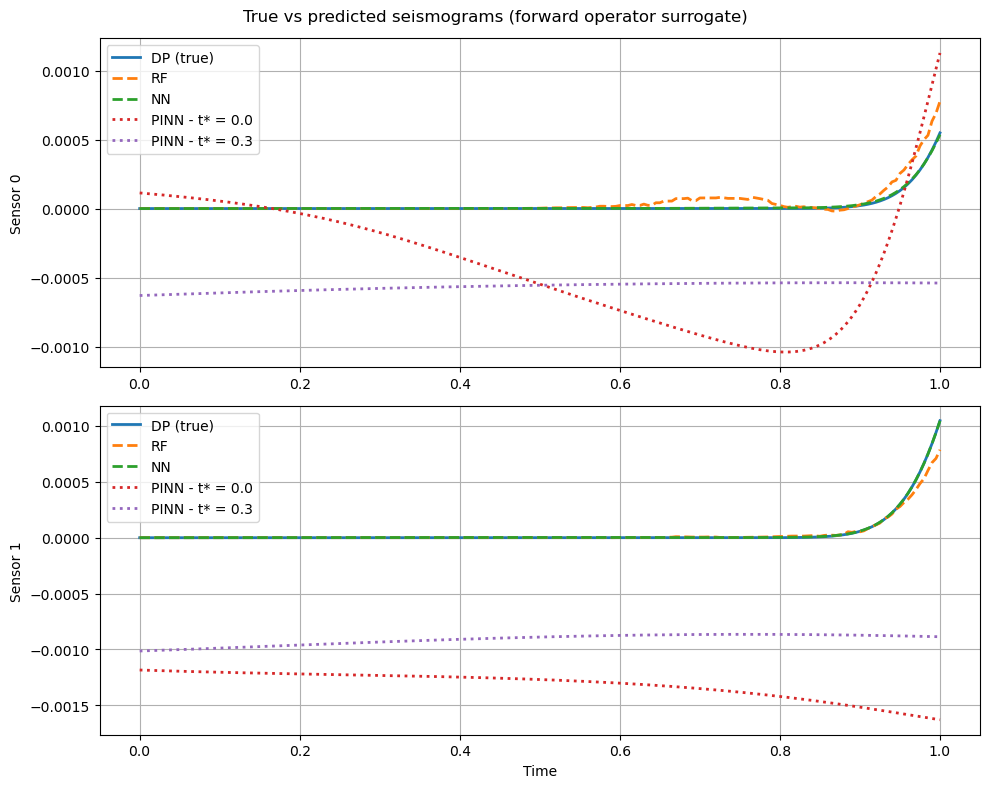

In [ ]:
traces_ml = predict_traces(model_ml, sensors, Nt, dp_forward_solver.T, e_x=e_true[0], e_y=e_true[1]).cpu()


t = np.linspace(0, dp_forward_solver.T, Nt)
K = traces_obs.shape[1]
plt.figure(figsize=(10, 4 * K))

for k in range(K):
    plt.subplot(K, 1, k + 1)
    plt.plot(t, traces_obs[:, k], label="DP (true)", linewidth=2)
    plt.plot(t, traces_ml[:, k], "--", label="RF", linewidth=2)
    plt.plot(t, traces_nn[:, k], "--", label="NN", linewidth=2)
    plt.plot(t, traces_pinn_t0[:, k], ":", label="PINN - t* = 0.0", linewidth=2)
    # plt.plot(t, traces_pinn_t03[:, k], ":", label="PINN - t* = 0.3", linewidth=2)
    plt.ylabel(f"Sensor {k}")
    plt.legend()
    plt.grid(True)

plt.xlabel("Time")
plt.suptitle("True vs predicted seismograms (forward operator surrogate)")
plt.tight_layout()
plt.show()

In [95]:
print('Using different forward solver as surrogate :\n')
print("True epicenter :", e_true)

print("DP :", (float(e_hat_dp[0]), float(e_hat_dp[1])))
print("PINN (t* = 0.0) :", (float(e_hat_pinn_t0[0]), float(e_hat_pinn_t0[1])))
# print("PINN (t* = 0.3) :", (float(e_hat_pinn_t03[0]), float(e_hat_pinn_t03[1])))
print("NN : ",(float(e_hat_nn[0]), float(e_hat_nn[1])))

Using different forward solver as surrogate :

True epicenter : (0.25, -0.1)
DP : (0.25000008940696716, -0.1000000610947609)
PINN (t* = 0.0) : (-0.6330297589302063, 0.6146997213363647)
NN :  (0.24208110570907593, -0.09424494206905365)
